In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import os

In [3]:
DATA_DIR = 'data'
TRAIN_SIZE = 0.7
VALID_SIZE = 0.2
BUFFER_SIZE = 256
TRAIN_TFRECORD_FILENAME = 'train.tfrecord'
VALID_TFRECORD_FILENAME = 'valid.tfrecord'
TEST_TFRECORD_FILENAME = 'test.tfrecord'

# Load data

The applause audio is converted into .wav from [here](https://www.youtube.com/watch?v=w0xbP83McGk). The audio contains segments from multiple types of applauses, some of which include cheering. 

The classical music audio consists of famous short orchestral, piano, and vocal pieces.

Although it is possible to achieve more data diversity by sampling from a broader range of YouTube videos, the current dataset achieves sufficient diversity without explicit labeling.

In [4]:
applauses, applauses_sampling_rate = tf.audio.decode_wav(tf.io.read_file(os.path.join(DATA_DIR, 'applauses.wav')))
music, music_sampling_rate = tf.audio.decode_wav(tf.io.read_file(os.path.join(DATA_DIR, 'music.wav')))

applauses.shape, music.shape, applauses_sampling_rate, music_sampling_rate

(TensorShape([35938304, 2]),
 TensorShape([127437824, 2]),
 <tf.Tensor: shape=(), dtype=int32, numpy=44100>,
 <tf.Tensor: shape=(), dtype=int32, numpy=44100>)

We decided to split the audio into segments of around 0.25 seconds. Each segment then would be evaluated independently.  If the sampling rate differs between different audio data, then the batch_size must stay the same.

In [5]:
def split_data(d, d_sampling_rate):
    data_size = d.shape[0]
    batch_size = d_sampling_rate // 4 # split into 0.25 second intervals
    batch_count = data_size // batch_size 
    return np.array_split(d[:batch_count * batch_size], batch_count)

In [6]:
applauses_split = split_data(applauses, applauses_sampling_rate)
music_split = split_data(music, music_sampling_rate)

len(applauses_split), len(music_split)

(3259, 11558)

Labeling is very simple, as we simply assign 0 to music and 1 to applauses before shuffling them.

In [7]:
applauses_labels, music_labels = np.ones(len(applauses_split)), np.zeros(len(music_split))

In [8]:
X_unshuffled = applauses_split + music_split
y_unshuffled = np.concatenate((applauses_labels, music_labels), axis=0)

In [9]:
DATA_SIZE = len(X_unshuffled)

# Visualize data

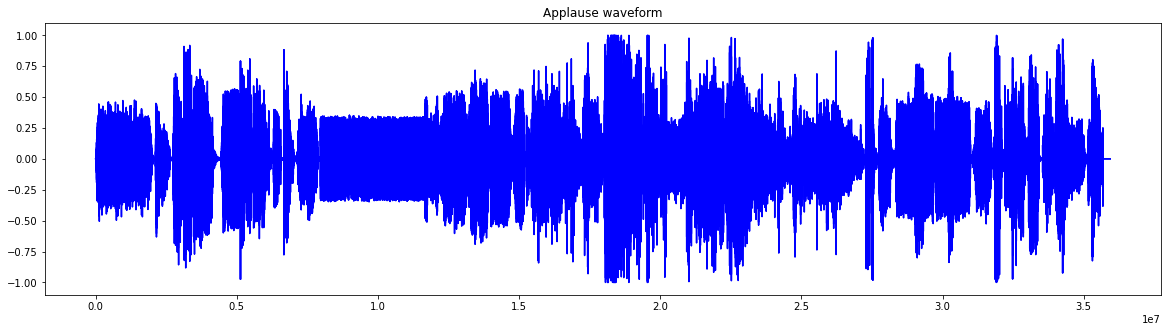

In [13]:
fig = plt.figure(figsize=(20, 5))
plt.plot(applauses, color='blue')
plt.title('Applause waveform')
plt.show()

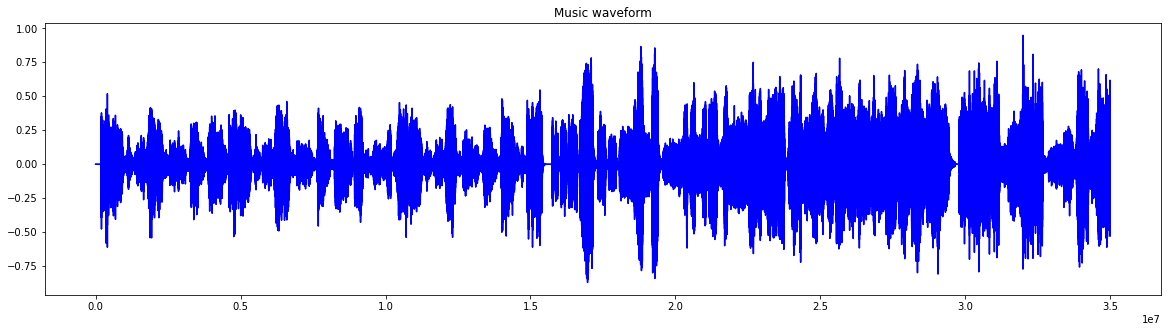

In [12]:
fig = plt.figure(figsize=(20, 5))
plt.plot(music[:35000000], color='blue')
plt.title('Music waveform')
plt.show()

# Converting to Tensorflow Dataset

In [11]:
waveform_dataset = tf.data.Dataset.from_tensor_slices(X_unshuffled)
label_dataset = tf.data.Dataset.from_tensor_slices(y_unshuffled)

In [12]:
dataset = tf.data.Dataset.zip((waveform_dataset, label_dataset))

In [13]:
dataset = dataset.shuffle(DATA_SIZE).prefetch(BUFFER_SIZE)

In [14]:
train_dataset = dataset.take(int(TRAIN_SIZE * DATA_SIZE))
valid_dataset = dataset.skip(int(TRAIN_SIZE * DATA_SIZE)).take(int(VALID_SIZE * DATA_SIZE))
test_dataset = dataset.skip(int((TRAIN_SIZE + VALID_SIZE) * DATA_SIZE))

# Export

In [31]:
def serialize_example(waveform, label):
    waveform_serialized = tf.io.serialize_tensor(waveform)
    feature = {
        'waveform': tf.train.Feature(bytes_list=tf.train.BytesList(value=[waveform_serialized.numpy()])),
        'label': tf.train.Feature(float_list=tf.train.FloatList(value=[label.numpy()]))
    }
    
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [33]:
def tf_serialize_example(waveform, label):
    # This is so confusing how we had to convert tensors into numpy inside this function,
    # and now we are reverting it back to a graph
    tf_string = tf.py_function(
        serialize_example,
        (waveform, label),
        tf.string)
    return tf.reshape(tf_string, ())

In [36]:
for i, j in dataset.take(1):
    print(tf_serialize_example(i, j))

tf.Tensor(b'\n\xc6\xb1\x05\n\xaf\xb1\x05\n\x08waveform\x12\xa1\xb1\x05\n\x9d\xb1\x05\n\x99\xb1\x05\x08\x01\x12\t\x12\x03\x08\x91V\x12\x02\x08\x02"\x88\xb1\x05\x00\x00\xc0\xb8\x00\x00`;\x00\x008;\x00\x00\xae;\x00\x00\xa4;\x00\x00\xbe;\x00\x00\x9b;\x00\x00h;\x00\x00b;\x00\x00\xe09\x00\x00\xb8:\x00\x00\x18\xbb\x00\x00\x84\xba\x00\x00\xa0\xbb\x00\x00$\xbb\x00\x00\xe9\xbb\x00\x00"\xbb\x00\x80\x0c\xbc\x00\x00\x94\xba\x00\x80\x16\xbc\x00\x00\xa09\x00\x00\x11\xbc\x00\x00P:\x00\x00\xe7\xbb\x00\x00X:\x00\x00\x83\xbb\x00\x00\xc09\x00\x00\x00\xba\x00\x00\xe0\xb9\x00\x00F;\x00\x00\x90\xb9\x00\x00\xc1;\x00\x00\x00\xb9\x00\x00\xe8;\x00\x00\xf0\xba\x00\x00\xc1;\x00\x00r\xbb\x00\x00\x84;\x00\x00j\xbb\x00\x00\x86;\x00\x00\x1e\xbb\x00\x00\xa9;\x00\x00\xe8\xba\x00\x00\x87;\x00\x00\xb4\xba\x00\x00\x04;\x00\x00\x80\xb9\x00\x00\x90:\x00\x00\x9c:\x00\x00(:\x00\x00\x06;\x00\x00`:\x00\x00H;\x00\x00*;\x00\x00\x8a;\x00\x00\x81;\x00\x00\x98;\x00\x00\x85;\x00\x00\xb2;\x00\x00\x96;\x00\x00\xd9;\x00\x00\xaf;\x00\x00\

In [56]:
serialized_train_dataset = train_dataset.map(tf_serialize_example)
serialized_valid_dataset = valid_dataset.map(tf_serialize_example)
serialized_test_dataset = test_dataset.map(tf_serialize_example)

In [59]:
train_writer = tf.data.experimental.TFRecordWriter(os.path.join(DATA_DIR, TRAIN_TFRECORD_FILENAME))
train_writer.write(serialized_train_dataset)
valid_writer = tf.data.experimental.TFRecordWriter(os.path.join(DATA_DIR, VALID_TFRECORD_FILENAME))
valid_writer.write(serialized_valid_dataset)
test_writer = tf.data.experimental.TFRecordWriter(os.path.join(DATA_DIR, TEST_TFRECORD_FILENAME))
test_writer.write(serialized_test_dataset)